In [27]:
import pandas as pd
from common import get_set, sns_cm, acc_names, rate_gyro_names, display_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import import_ipynb as ipynb

In [28]:
%%capture
m_knn = ipynb.NotebookLoader().load_module('movements_knn')

#### Testing set

In [72]:
testing_set = m_knn.testing_set

##### Hyperparameters

In [75]:
folds = KFold(n_splits=40)
k_range = list(range(1, 50))

param_grid = {
    'max_depth': list(range(1, 50)),
    'criterion': ['gini', 'entropy']
}

In [76]:
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid=dict(n_neighbors=k_range),
                        cv=folds,
                        scoring='accuracy',
                        return_train_score=False)

grid_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                       param_grid=param_grid,
                       cv=folds,
                       scoring='accuracy',
                       return_train_score=False)

In [77]:
classes = get_set("Class Dataframes")

# Feature Transformation

#### Transform all features using rolling with the parameter 10. Tip: store the transformed dataframes in new pickle files. You never know if you need them later

In [ ]:
window = 10

#### Applying rolling to the testing set.

In [ ]:
testing_set_tra = testing_set.drop('class', axis='columns').rolling(window=window).std()
testing_set_tra.dropna(how='any', inplace=True)
testing_set_tra['class'] = testing_set.drop(testing_set.index[:window])['class']
testing_set_tra = testing_set_tra.dropna(how='any').reset_index(drop=True)

#### Split training set with applied rolling(50)

In [ ]:
X_sample = testing_set_tra.drop('class', axis='columns')
y_sample_true = testing_set_tra['class']

#### Applying rolling to the training set for each class.

In [79]:
for _class in classes:
    transformed_df = _class.drop('class', axis='columns').rolling(window=window).std()
    transformed_df.dropna(how='any', inplace=True)
    transformed_df['class'] = _class['class'][0]
    transformed_df.to_pickle(f"../Binaries/Transformed/{_class['class'][0]}.pkl")

### What does the parameter (.rolling(10)) mean?
##### pd.DataFrame().rolling(10) is the window size; it is usually used with mean(), std()... In the case of std(), a rolling(10) means it will move through the rows at 10 intervals, meaning it will consider 10 rows at a time. Then, it will calculate the standard deviation of the 10 rows. The resulting dataframe size will be equal to the input dataframe, however, the first nine rows will be NaN. For example, the 9th row will be std of 0-9 rows, the 10th will be of std of 2-10 rows.

In [80]:
transformed_classes = get_set(folder="Transformed", positions=['Squats', 'Jumping', 'Running', 'Walking'])
transformed_df = pd.concat(transformed_classes, axis='rows', ignore_index=True)

# Make the classification again (same classes as above) as previously, with KNN or Decision Trees. Compare the results with previous, untransformed features. Is the result improved?

In [81]:
X = transformed_df.drop('class', axis='columns')
y = transformed_df['class']

In [82]:
X

,ax,ay,az,gx,gy,gz
0,1.776297,4.921281,2.119761,0.244905,0.883705,0.136775
1,1.447607,5.149444,1.864505,0.288307,0.784616,0.159200
2,1.089899,5.339574,2.123630,0.344764,0.625200,0.177394
3,0.801757,5.346881,2.463617,0.412902,0.491671,0.193743
4,0.546549,5.178144,2.539711,0.476720,0.520233,0.208623
...,...,...,...,...,...,...
18389,0.765423,0.403546,0.383118,0.211814,0.071118,0.110405
18390,0.844488,0.450594,0.460811,0.196009,0.077323,0.113434
18391,0.819262,0.506355,0.445318,0.162584,0.103616,0.102874
18392,0.711692,0.518837,0.398086,0.119487,0.135967,0.082126


In [83]:
y

0        Jumping
1        Jumping
2        Jumping
3        Jumping
4        Jumping
          ...   
18389    Walking
18390    Walking
18391    Walking
18392    Walking
18393    Walking
Name: class, Length: 18394, dtype: object

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

# KNN with transformed

In [85]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=40, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

##### What is the optimal k-value?

In [86]:
grid_knn.best_params_

{'n_neighbors': 3}

##### What is the accuracy?

In [87]:
grid_knn.best_score_

0.7486949857836749

##### Display scores

In [88]:
scores = pd.DataFrame(grid_knn.cv_results_)

In [89]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014691,0.003322,0.010654,0.010516,1,{'n_neighbors': 1},0.733696,0.752717,0.739130,0.741848,...,0.741848,0.733696,0.724796,0.746594,0.735695,0.749319,0.765668,0.743935,0.017455,5
1,0.013714,0.000640,0.009303,0.000732,2,{'n_neighbors': 2},0.725543,0.684783,0.744565,0.703804,...,0.728261,0.703804,0.743869,0.741144,0.675749,0.724796,0.757493,0.718862,0.024982,31
2,0.013368,0.000467,0.009198,0.000723,3,{'n_neighbors': 3},0.701087,0.744565,0.730978,0.736413,...,0.744565,0.733696,0.749319,0.790191,0.732970,0.749319,0.768392,0.748695,0.021400,1
3,0.013496,0.000620,0.009569,0.000836,4,{'n_neighbors': 4},0.698370,0.720109,0.733696,0.730978,...,0.752717,0.730978,0.760218,0.773842,0.735695,0.746594,0.768392,0.743464,0.020461,6
4,0.013535,0.000619,0.009787,0.000824,5,{'n_neighbors': 5},0.722826,0.733696,0.744565,0.750000,...,0.744565,0.752717,0.754768,0.757493,0.741144,0.754768,0.724796,0.744411,0.017908,3
5,0.013719,0.000773,0.010060,0.000848,6,{'n_neighbors': 6},0.720109,0.717391,0.771739,0.736413,...,0.744565,0.747283,0.743869,0.757493,0.754768,0.754768,0.735695,0.745024,0.019024,2
6,0.013355,0.000556,0.009963,0.000962,7,{'n_neighbors': 7},0.714674,0.725543,0.769022,0.750000,...,0.736413,0.747283,0.741144,0.752044,0.746594,0.743869,0.741144,0.744003,0.018120,4
7,0.013654,0.000848,0.010201,0.001405,8,{'n_neighbors': 8},0.720109,0.717391,0.760870,0.747283,...,0.747283,0.747283,0.711172,0.749319,0.752044,0.741144,0.743869,0.741759,0.018474,7
8,0.013503,0.000738,0.009975,0.000611,9,{'n_neighbors': 9},0.706522,0.750000,0.752717,0.741848,...,0.750000,0.728261,0.719346,0.752044,0.741144,0.746594,0.757493,0.740062,0.017977,8
9,0.013841,0.001096,0.010340,0.000910,10,{'n_neighbors': 10},0.717391,0.720109,0.763587,0.730978,...,0.736413,0.741848,0.719346,0.762943,0.752044,0.743869,0.752044,0.737482,0.017789,11


##### Plot the accuracy as a function of the k-value.

<Axes: title={'center': 'Accuracy'}, xlabel='k'>

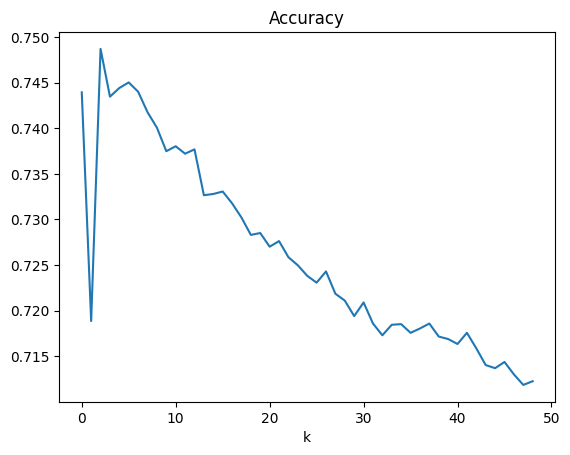

In [90]:
scores['mean_test_score'].plot(title='Accuracy', xlabel='k')

##### Predict

In [91]:
y_pred_knn = grid_knn.predict(X=X_test)
y_pred_sample_knn = grid_knn.predict(X=X_sample)

In [92]:
display_accuracy(accuracy_score(y_true=y_test, y_pred=y_pred_knn), accuracy_score(y_true=y_sample_true, y_pred=y_pred_sample_knn))

Validation set accuracy: 0.745854851861919
Test set accuracy: 0.6862265688671557


##### Confusion matrix of the validation set

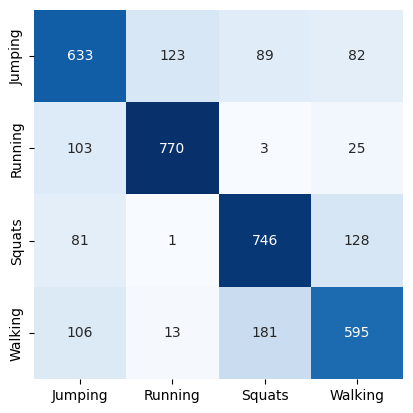

In [93]:
sns_cm(y_true=y_test, y_pred=y_pred_knn)

##### Confusion matrix of the testing set

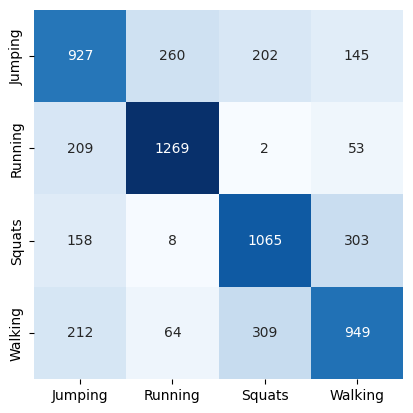

In [94]:
sns_cm(y_true=y_sample_true, y_pred=y_pred_sample_knn)

# Decision tree transformed

In [95]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=40, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

##### Best hyper parameters

In [96]:
grid_dt.best_params_

{'criterion': 'entropy', 'max_depth': 14}

##### What is the accuracy?

In [97]:
grid_dt.best_score_

0.7188605097144889

##### Display scores

In [98]:
scores_dt = pd.DataFrame(grid_dt.cv_results_)

##### Does the criterion have an impact on the accuracy? Make an investigation so you can answer this question

In [99]:
scores_dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024361,0.002279,0.001184,0.000450,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.421196,0.418478,0.429348,...,0.423913,0.418478,0.416894,0.405995,0.438692,0.414169,0.460490,0.425349,0.026084,98
1,0.040526,0.001223,0.001332,0.000438,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.486413,0.505435,0.584239,...,0.559783,0.554348,0.506812,0.531335,0.512262,0.523161,0.607629,0.539381,0.026231,95
2,0.057128,0.001988,0.001176,0.000503,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.527174,0.548913,0.635870,...,0.595109,0.597826,0.528610,0.569482,0.564033,0.591281,0.651226,0.576013,0.028933,93
3,0.074269,0.004000,0.001219,0.000511,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.597826,0.600543,0.663043,...,0.649457,0.630435,0.613079,0.618529,0.613079,0.615804,0.675749,0.626504,0.028227,91
4,0.089457,0.005391,0.001246,0.000460,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.627717,0.622283,0.682065,...,0.676630,0.654891,0.618529,0.670300,0.618529,0.640327,0.702997,0.642816,0.028225,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.255048,0.013077,0.001278,0.000489,entropy,45,"{'criterion': 'entropy', 'max_depth': 45}",0.728261,0.714674,0.698370,...,0.728261,0.692935,0.702997,0.716621,0.771117,0.741144,0.732970,0.715466,0.022967,21
94,0.255220,0.009741,0.001100,0.000342,entropy,46,"{'criterion': 'entropy', 'max_depth': 46}",0.722826,0.711957,0.690217,...,0.730978,0.695652,0.692098,0.705722,0.768392,0.727520,0.719346,0.713832,0.022503,38
95,0.257476,0.010555,0.001354,0.000590,entropy,47,"{'criterion': 'entropy', 'max_depth': 47}",0.733696,0.720109,0.703804,...,0.725543,0.703804,0.678474,0.711172,0.746594,0.741144,0.722071,0.714307,0.021056,34
96,0.257818,0.012722,0.001336,0.000571,entropy,48,"{'criterion': 'entropy', 'max_depth': 48}",0.722826,0.720109,0.687500,...,0.725543,0.682065,0.678474,0.705722,0.752044,0.735695,0.724796,0.714171,0.022872,35


##### Tree

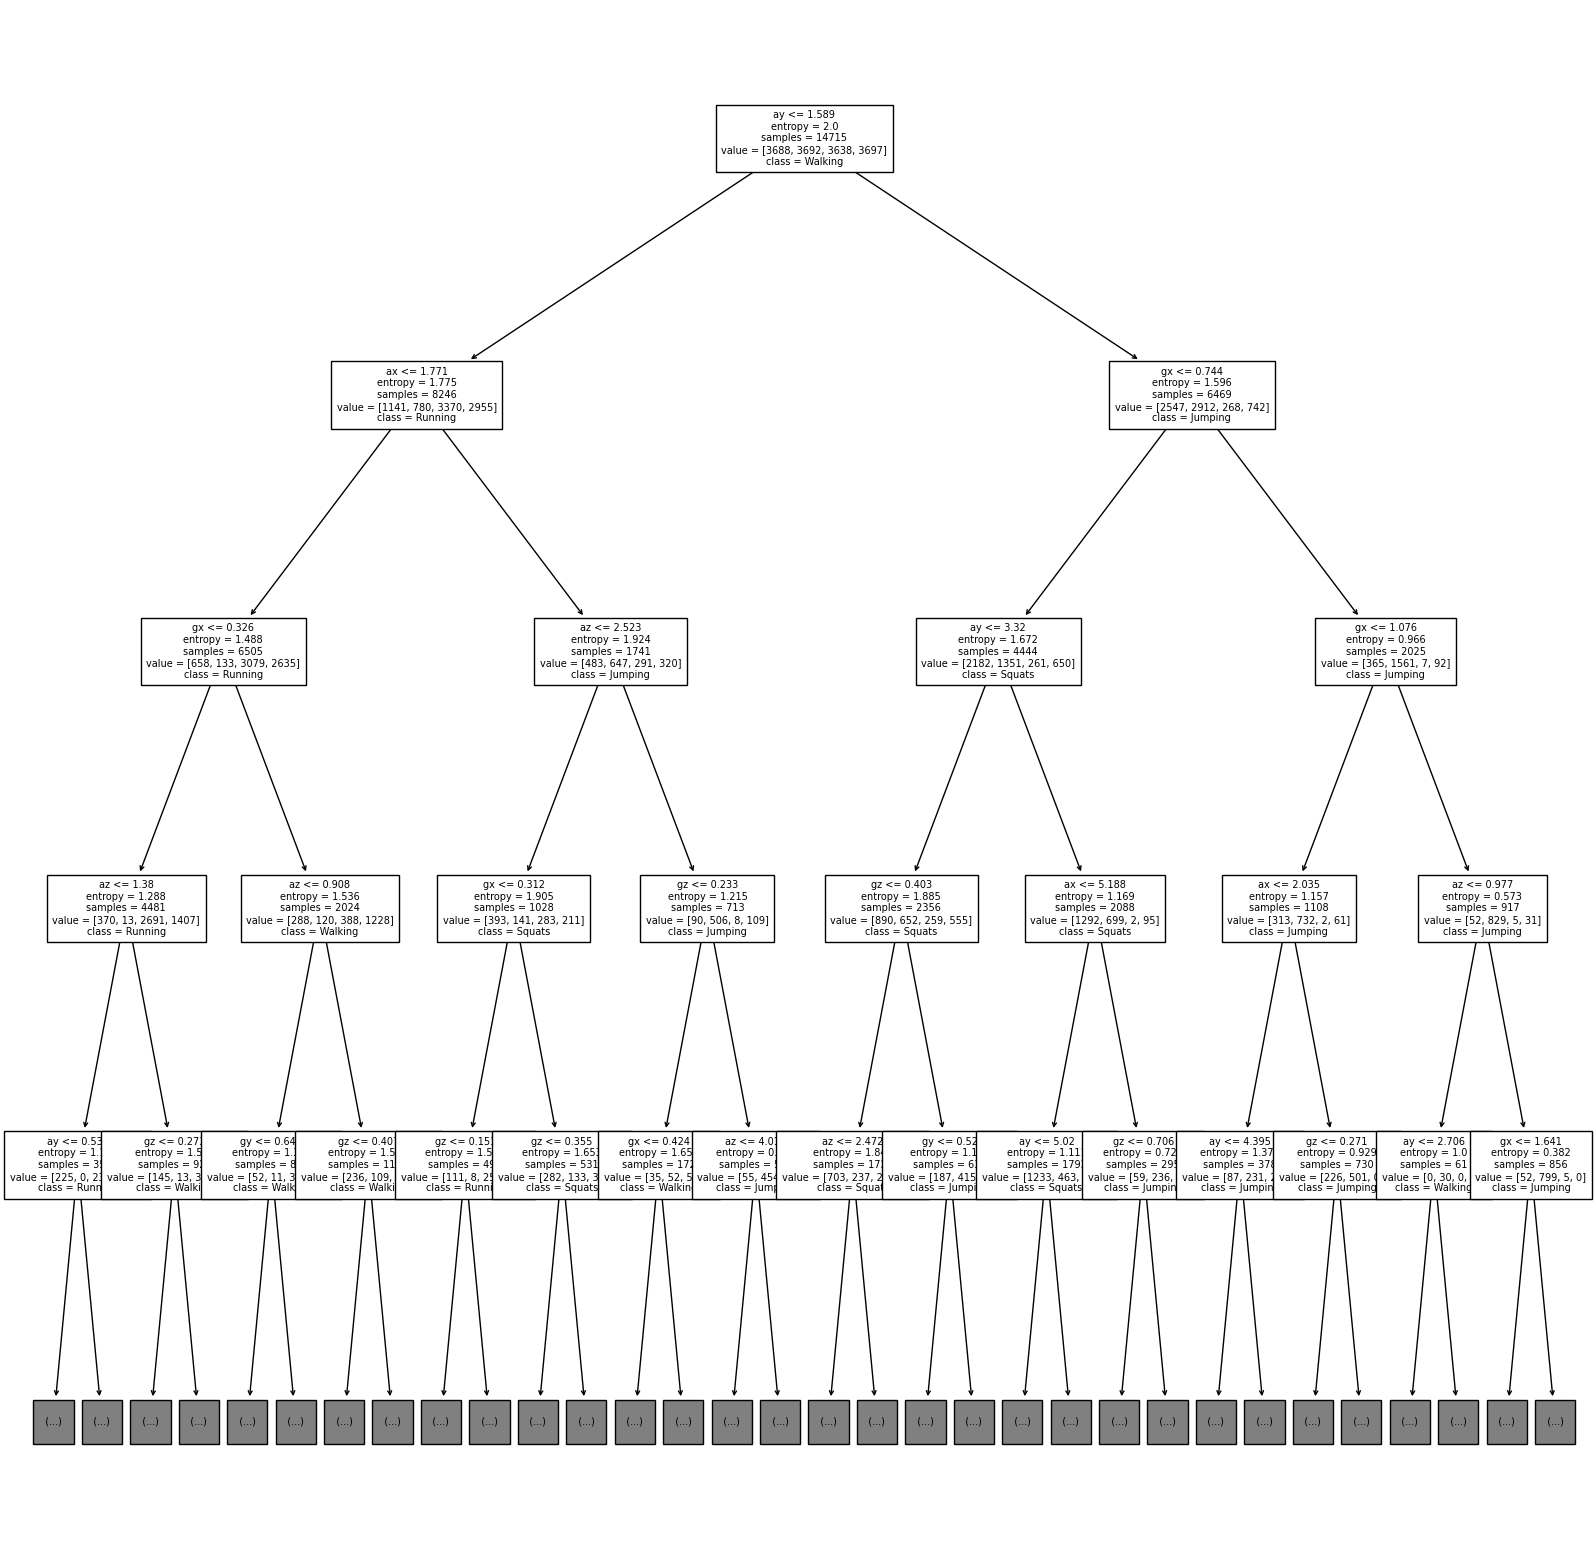

In [100]:
plt.figure(figsize=(20, 20))
plot_tree(
    decision_tree=grid_dt.best_estimator_,
    feature_names= acc_names + rate_gyro_names,
    class_names=['Squats', 'Jumping', 'Running', 'Walking'],
    fontsize=7,
    max_depth=4
)
plt.show()

##### Predict

In [101]:
y_pred_dt = grid_dt.predict(X=X_test)
y_pred_sample_dt = grid_dt.predict(X=X_sample)

In [102]:
display_accuracy(accuracy_score(y_true=y_test, y_pred=y_pred_knn), accuracy_score(y_true=y_sample_true, y_pred=y_pred_sample_dt))

Validation set accuracy: 0.745854851861919
Test set accuracy: 0.6707416462917686


##### Confusion matrix of the validation set

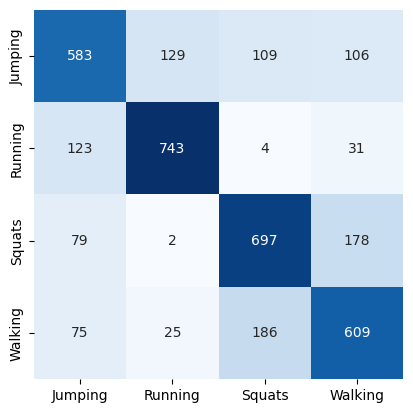

In [103]:
sns_cm(y_test, y_pred_dt)

##### Confusion matrix of the testing set

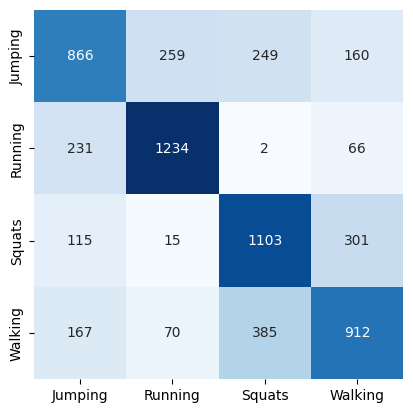

In [104]:
sns_cm(y_sample_true, y_pred_sample_dt)